In [1]:
import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import datasets
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix

from transformer_utils import TransformerEncoder, PositionEmbedding, get_masks

In [2]:
dataset = datasets.load_dataset("ag_news")['train']

Using custom data configuration default
Reusing dataset ag_news (/home/urchade.zaratiana/.cache/huggingface/datasets/ag_news/default/0.0.0/fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a)


In [3]:
dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=4, names=['World', 'Sports', 'Business', 'Sci/Tech'], names_file=None, id=None)}

In [4]:
# create vocab file

all_text = ''.join([el['text'] for el in dataset])

vocab_file = 'vocab_ag_news.txt'

with open(vocab_file, 'w') as f:
    f.write(all_text)

### Training a bert tokenizer

In [5]:
# ! pip install tokenizers

from tokenizers import BertWordPieceTokenizer
from tokenizers.processors import TemplateProcessing

In [6]:
bert_tokenizer = BertWordPieceTokenizer()

In [7]:
bert_tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A [SEP]",
    special_tokens=[
        ("[CLS]", 1),
        ("[SEP]", 2),
    ],
)

In [8]:
bert_tokenizer.train(['vocab_ag_news.txt'], vocab_size=20000)

### Dataset and data loaders

In [13]:
class TextDataset(Dataset):
    
    def __init__(self, dataset):
        
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        
        x = self.dataset[idx]['text']
        y = self.dataset[idx]['label']
        
        return x, y

In [14]:
def collate(batch):
        
    bert_tokenizer.enable_truncation(100)
    bert_tokenizer.enable_padding()
    
    src = bert_tokenizer.encode_batch([item[0] for item in batch])
    
    src = torch.LongTensor([i.ids for i in src])
        
    y = torch.LongTensor([item[1] for item in batch])
        
    return [src, y]

In [15]:
all_dataset = TextDataset(dataset)

print(len(dataset))

train, val = random_split(all_dataset, [len(all_dataset)-5000, 5000])

train_loader = DataLoader(train, batch_size=128, shuffle=True, collate_fn=collate, num_workers=15)

val_loader = DataLoader(val, batch_size=512, shuffle=False, collate_fn=collate, num_workers=11)

120000


### PetitBERT model

Very short summary of bert pre-training

Bert base: vocab_size ~ 30.000, d_model=768, n_head=12, num_layers=12

Bert was trained with two tasks: <strong>Masked language modeling</strong> & <strong>Next-sentence prediction</strong>

<strong>Masked language modeling</strong>

    - model: bert = TransformerEncoder(....)

    - input x
        ex:  '[x1, x2, [MASK], x4]'
    
    - target y
        ex:  [ 0, 0, x3, 0 ]

    - compute prediction
        pred = softmax_layer(bert(x))

    - compute loss
        mlm_loss = cross_entropy(pred, y, ignore_index=0)

    - optimize loss with gradient descent

<strong>Next-sentence prediction</strong>

    - model: bert = TransformerEncoder(....)

    - input x
        ex:  [[CLS], x1, x2, [SEP], x3, x4, [SEP]]
    
    - target y
        ex:  [0] or [1]

    - compute prediction
        cls_rep = bert(x)[CLS]
        pred = sigmoid_layer(cls_rep)

    - compute loss
        nsp_loss = binary_cross_entropy(pred, y)

    - optimize loss with gradient descent
 
The two tasks are performed at the same time (multi-task learning)

In [16]:
# No pre-training for our petit bert ... :(

class PetitBERT(nn.Module):
    
    def __init__(self, vocab_size, d_model=128, n_head=4, num_layers=2):
        
        super().__init__()
        
        self.d_model = d_model
        
        self.word_embeddings = nn.Embedding(vocab_size, d_model, padding_idx=0)
        
        # positional embedding
        self.pos_embedding = PositionEmbedding(max_position=250, d_model=d_model)
        
        self.layers = TransformerEncoder(d_model, n_head, num_layers)
        
        self.pooler = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Tanh()
        )
        
    def forward(self, x):
        
        att_mask, _ = get_masks(x)
        
        x = self.word_embeddings(x) * np.sqrt(self.d_model)
        
        x = self.pos_embedding(x)
        
        # [batch_size, s_len, d_model]
        x = self.layers(x, att_mask) 
        
        # get representation of [CLS] token
        pool_cls = self.pooler(x[:, 0, :])
        
        return x, pool_cls 

In [17]:
class BertClassifier(nn.Module):
    
    def __init__(self, num_classes, vocab_size, d_model=128, n_head=4, num_layers=2):
        
        super().__init__()
        
        self.bert = PetitBERT(vocab_size, d_model, n_head, num_layers)
        
        self.fc = nn.Linear(d_model, num_classes)
        
    def forward(self, x):
        
        _, cls_token_rep = self.bert(x)
                
        return self.fc(cls_token_rep)
    
    def compute_loss(self, x, y):
        
        y_hat = self.forward(x)
        
        loss = F.cross_entropy(y_hat, y)
        
        return loss

In [18]:
def train_one_epoch(net: nn.Module, opt: torch.optim, dataloader: torch.utils.data.DataLoader):
    
    net.train()
    
    for param in net.parameters():
        device = param.device
        break
    
    losses = []
    
    pbar = tqdm(dataloader)
    
    for x, y in pbar:

        net.zero_grad()

        x, y = x.to(device), y.to(device)

        loss = net.compute_loss(x, y)

        loss.backward()

        opt.step()
        
        loss_item = loss.item()
        
        losses.append(loss_item)
        
        pbar.set_description(f'train_loss = {np.array(losses).mean()}')
        
    return np.array(losses).mean()

@torch.no_grad()
def validate(net: nn.Module, dataloader: torch.utils.data.DataLoader):
    
    net.eval()
    
    for param in net.parameters():
        device = param.device
        break
     
    y_true = []
    y_pred = []
    
    for x, y in dataloader:

        x = x.to(device)

        logits = net(x)
        
        y_hat = torch.argmax(logits, dim=1)
        
        y_pred.extend(y_hat.cpu().numpy().tolist())
        
        y_true.extend(y.numpy().tolist())
    
    return accuracy_score(y_true, y_pred), confusion_matrix(y_true, y_pred, normalize='true')

In [19]:
model = BertClassifier(4, bert_tokenizer.get_vocab_size()).cuda()

opt = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [21]:
# number of parameters
# ~~10 times smaller than bert base

np.sum([p.numel() for p in model.parameters()])

3267972

In [22]:
label_list = ['World', 'Sports', 'Business', 'Sci/Tech']

def plot_conf(conf_mat):
    sns.heatmap(conf_mat, annot=True, cbar=False, square=True, xticklabels=label_list, yticklabels=label_list)
    plt.show()

val_acc = 0.2508


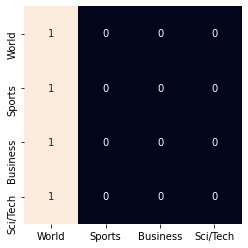

train_loss = 0.7097029953830367: 100%|██████████| 899/899 [01:32<00:00,  9.73it/s]


val_acc = 0.8296


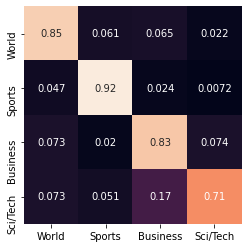

train_loss = 0.43758660064129057:  19%|█▊        | 167/899 [00:13<01:00, 12.17it/s]

In [ ]:
model.cuda()

for i in range(5):
    
    if i==0:
        acc, conf_mat = validate(model, val_loader)
        
        print(f'val_acc = {acc}')
        
        plot_conf(conf_mat)
        
    train_one_epoch(model, opt, train_loader)
    
    acc, conf_mat = validate(model, val_loader)
    
    print(f'val_acc = {acc}')

    plot_conf(conf_mat)